## Schema identifier classifications

In [20]:
import pandas as pd 
import seaborn as sns

In [21]:
consolidated_score_file = "./data/gold-data/consolidated-scores-5-9-2024-no_whitespace.xlsx"

column_identifier_scores = pd.read_excel(
    consolidated_score_file,
    sheet_name="distinct-column"
)
column_identifier_scores['COLUMN_NAME'] = column_identifier_scores.apply(
    lambda row: row.COLUMN_NAME.lower(),
    axis=1
)
column_identifier_scores = column_identifier_scores[['COLUMN_NAME', 'FINAL_SCORE']].drop_duplicates()
column_identifier_scores.set_index("COLUMN_NAME", inplace=True)

table_identifier_scores = pd.read_excel(
    consolidated_score_file,
    sheet_name="distinct-table"
)
table_identifier_scores['TABLE_NAME'] = table_identifier_scores.apply(
    lambda row: row.TABLE_NAME.lower(),
    axis=1
)
table_identifier_scores = table_identifier_scores[['TABLE_NAME', 'FINAL_SCORE']].drop_duplicates()
table_identifier_scores.set_index("TABLE_NAME", inplace=True)

all_schemas_full = pd.read_excel(
    consolidated_score_file,
    sheet_name="all-scores"
)
all_schemas_full['TABLE_NAME'] = all_schemas_full.apply(
    lambda row: row.TABLE_NAME.lower(),
    axis=1
)
all_schemas_full['COLUMN_NAME'] = all_schemas_full.apply(
    lambda row: row.COLUMN_NAME.lower(),
    axis=1
)

all_schemas_full["DB_NAME_EXPANDED"] = all_schemas_full["DATABASE_NAME"]

cat_label_dict = {
    'N1': 'Regular', 'N2': 'Low', 'N3': 'Least', 
    'NATIVE': 'Native Schema', 'combined': 'Combined',
    "COMBINED": "Combined"
    }

all_schemas_full = all_schemas_full[[
    'DATABASE_NAME', "DB_NAME_EXPANDED", 'TABLE_NAME', 'COLUMN_NAME', 'MODEL'
    ]]
all_schemas_full.describe()



,DATABASE_NAME,DB_NAME_EXPANDED,TABLE_NAME,COLUMN_NAME,MODEL
count,193878,193878,193878,193878,193878
unique,179,179,3926,15683,2
top,SBODemoUS-canine,SBODemoUS-canine,oadm,loginstanc,davinci:ft-personal:tagged-classifier-fixed-20...
freq,90477,90477,1126,3090,103401


In [22]:
database_label_dict = {
    "ASIS_20161108_HerpInv_Database": "ASIS",
    "ATBI": "ATBI",
    "CratersWildlifeObservations": "CWO",
    "KlamathInvasiveSpecies": "KIS",
    "NTSB": "NTSB",
    "NYSED_SRC2022": "NYSED",
    "NorthernPlainsFireManagement": "NPFM",
    "PacificIslandLandbirds": "PILB",
    "SBODemoUS-Banking": "SBOD",
    'SBODemoUS-Business Partners': "SBOD", 
    'SBODemoUS-Finance': "SBOD",
    'SBODemoUS-General': "SBOD", 
    'SBODemoUS-Human Resources': "SBOD",
    'SBODemoUS-Inventory and Production': "SBOD", 
    'SBODemoUS-Reports': "SBOD",
    'SBODemoUS-Sales Opportunities': "SBOD", 
    'SBODemoUS-Service': "SBOD",
    "SBODemoUS": "SBOD",
    "bird-all": "Bird",
    "spider": "Spider",
    "BUIS_HIS": "BUIS",
    "MacroInvertebrates": "MINV",
    "SchemaPile": "SchemaPile",
    "Spider-Realistic": "Spider-Real"
}

In [23]:
all_schemas = all_schemas_full.query(
    "MODEL == 'davinci:ft-personal:tagged-classifier-fixed-2023-07-10-23-28-14'"
    )
all_schemas["DATABASE_NAME"] = all_schemas.apply(
    lambda row: row.DATABASE_NAME.replace(".", ""),
    axis=1
)
all_schemas = all_schemas.join(
    column_identifier_scores,
    on="COLUMN_NAME",
    how="left",
    rsuffix="_column"
).join(
    table_identifier_scores,
    on="TABLE_NAME",
    how="left",
    rsuffix="_table"
).rename(
    columns={"FINAL_SCORE": "COLUMN_SCORE", "FINAL_SCORE_table": "TABLE_SCORE"}
    )[['DATABASE_NAME', 'DB_NAME_EXPANDED', 'TABLE_NAME', 'TABLE_SCORE', 'COLUMN_NAME', 'COLUMN_SCORE']]

all_schemas['DATABASE_NAME'] = all_schemas.apply(
    lambda row: row.DATABASE_NAME if 'spider' not in row.DATABASE_NAME else 'spider',
    axis=1
)
all_schemas.describe()
# bird["DB_NAME_EXPANDED"] = "bird-datasets"
# all_schemas = pd.concat([all_schemas, bird])
all_schemas["DB_LABEL"] = all_schemas.apply(
    lambda row: database_label_dict[row.DATABASE_NAME],
    axis=1
)

C:\Users\kyle.luoma\AppData\Local\Temp\ipykernel_44352\538787358.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_schemas["DATABASE_NAME"] = all_schemas.apply(


In [24]:
schemapile = pd.read_csv(
    "./data/schema-scores/schemapile/schemapile_scores.csv"
)

schemapile["DB_NAME_EXPANDED"] = schemapile["DATABASE_NAME"]
schemapile["DATABASE_NAME"] = "SchemaPile"


spider_realistic = pd.read_csv(
    "./data/schema-scores/spider-realistic/spider_realistic_scores.csv"
)
spider_realistic["DB_NAME_EXPANDED"] = spider_realistic["DATABASE_NAME"]
spider_realistic["DATABASE_NAME"] = "Spider-Realistic"

all_schemas = pd.concat([all_schemas, schemapile, spider_realistic])

In [25]:
db_table_naturalness_df = all_schemas[[
    "DATABASE_NAME", "DB_NAME_EXPANDED", "TABLE_SCORE", "TABLE_NAME"
    ]].drop_duplicates().groupby(
    ["DB_NAME_EXPANDED", "DATABASE_NAME", "TABLE_SCORE"]
    ).count().reset_index().pivot_table(
        columns="TABLE_SCORE",
        values="TABLE_NAME",
        index="DATABASE_NAME",
        aggfunc="sum"
    ).fillna(0)
db_table_naturalness_df

TABLE_SCORE,N1,N2,N3
DATABASE_NAME,,,
ASIS_20161108_HerpInv_Database,1.0,40.0,0.0
ATBI,1.0,27.0,0.0
BUIS_HIS,8.0,74.0,17.0
CratersWildlifeObservations,7.0,0.0,0.0
KlamathInvasiveSpecies,1.0,17.0,0.0
MacroInvertebrates,9.0,14.0,0.0
NTSB,19.0,16.0,5.0
NYSED_SRC2022,1.0,0.0,0.0
NorthernPlainsFireManagement,1.0,26.0,0.0


In [26]:
db_column_naturalness_df = all_schemas[[
    "DATABASE_NAME", "COLUMN_SCORE", "COLUMN_NAME"
    ]].groupby(
    ["DATABASE_NAME", "COLUMN_SCORE"]
).count().reset_index().pivot(
    columns="COLUMN_SCORE",
    values="COLUMN_NAME",
    index="DATABASE_NAME"
).fillna(0)
db_column_naturalness_df

COLUMN_SCORE,N1,N2,N3
DATABASE_NAME,,,
ASIS_20161108_HerpInv_Database,217,25,39
ATBI,118,43,31
BUIS_HIS,563,276,150
CratersWildlifeObservations,51,5,8
KlamathInvasiveSpecies,117,24,16
MacroInvertebrates,205,72,95
NTSB,490,389,282
NYSED_SRC2022,187,203,34
NorthernPlainsFireManagement,117,42,31


In [27]:
db_naturalness = db_table_naturalness_df.join(
    db_column_naturalness_df,
    lsuffix="_TABLE",
    rsuffix="_COLUMN"
)
for level in [1, 2, 3]:
    db_naturalness[f"N{level}_IDENTIFIER"] = db_naturalness.rename(columns={
        f"N{level}_TABLE": "TABLE", f"N{level}_COLUMN": "COLUMN"
    }).apply(
        lambda row: row.TABLE + row.COLUMN,
        axis=1
    )
db_naturalness["IDENT_COUNT"] = db_naturalness.apply(
    lambda row: sum([row.N1_IDENTIFIER, row.N2_IDENTIFIER, row.N3_IDENTIFIER]),
    axis=1
)
for level in [1, 2, 3]:
    db_naturalness[f"N{level}_PERC"] = db_naturalness.rename(columns={
        f"N{level}_IDENTIFIER": "IDENTIFIER"
    }).apply(
        lambda row: row.IDENTIFIER / row.IDENT_COUNT,
        axis=1
    )
db_naturalness

,N1_TABLE,N2_TABLE,N3_TABLE,N1_COLUMN,N2_COLUMN,N3_COLUMN,N1_IDENTIFIER,N2_IDENTIFIER,N3_IDENTIFIER,IDENT_COUNT,N1_PERC,N2_PERC,N3_PERC
DATABASE_NAME,,,,,,,,,,,,,
ASIS_20161108_HerpInv_Database,1.0,40.0,0.0,217,25,39,218.0,65.0,39.0,322.0,0.677019,0.201863,0.121118
ATBI,1.0,27.0,0.0,118,43,31,119.0,70.0,31.0,220.0,0.540909,0.318182,0.140909
BUIS_HIS,8.0,74.0,17.0,563,276,150,571.0,350.0,167.0,1088.0,0.524816,0.321691,0.153493
CratersWildlifeObservations,7.0,0.0,0.0,51,5,8,58.0,5.0,8.0,71.0,0.816901,0.070423,0.112676
KlamathInvasiveSpecies,1.0,17.0,0.0,117,24,16,118.0,41.0,16.0,175.0,0.674286,0.234286,0.091429
MacroInvertebrates,9.0,14.0,0.0,205,72,95,214.0,86.0,95.0,395.0,0.541772,0.217722,0.240506
NTSB,19.0,16.0,5.0,490,389,282,509.0,405.0,287.0,1201.0,0.423813,0.337219,0.238968
NYSED_SRC2022,1.0,0.0,0.0,187,203,34,188.0,203.0,34.0,425.0,0.442353,0.477647,0.080000
NorthernPlainsFireManagement,1.0,26.0,0.0,117,42,31,118.0,68.0,31.0,217.0,0.543779,0.313364,0.142857


In [28]:
comb_weights={'N1': 1, 'N2': .5, 'N3': 0}
db_naturalness["COMBINED"] = db_naturalness.apply(
    lambda row:
    row.N1_PERC * comb_weights["N1"] + 
    row.N2_PERC * comb_weights["N2"] +
    row.N3_PERC * comb_weights["N3"],
    axis=1
)
db_naturalness

,N1_TABLE,N2_TABLE,N3_TABLE,N1_COLUMN,N2_COLUMN,N3_COLUMN,N1_IDENTIFIER,N2_IDENTIFIER,N3_IDENTIFIER,IDENT_COUNT,N1_PERC,N2_PERC,N3_PERC,COMBINED
DATABASE_NAME,,,,,,,,,,,,,,
ASIS_20161108_HerpInv_Database,1.0,40.0,0.0,217,25,39,218.0,65.0,39.0,322.0,0.677019,0.201863,0.121118,0.777950
ATBI,1.0,27.0,0.0,118,43,31,119.0,70.0,31.0,220.0,0.540909,0.318182,0.140909,0.700000
BUIS_HIS,8.0,74.0,17.0,563,276,150,571.0,350.0,167.0,1088.0,0.524816,0.321691,0.153493,0.685662
CratersWildlifeObservations,7.0,0.0,0.0,51,5,8,58.0,5.0,8.0,71.0,0.816901,0.070423,0.112676,0.852113
KlamathInvasiveSpecies,1.0,17.0,0.0,117,24,16,118.0,41.0,16.0,175.0,0.674286,0.234286,0.091429,0.791429
MacroInvertebrates,9.0,14.0,0.0,205,72,95,214.0,86.0,95.0,395.0,0.541772,0.217722,0.240506,0.650633
NTSB,19.0,16.0,5.0,490,389,282,509.0,405.0,287.0,1201.0,0.423813,0.337219,0.238968,0.592423
NYSED_SRC2022,1.0,0.0,0.0,187,203,34,188.0,203.0,34.0,425.0,0.442353,0.477647,0.080000,0.681176
NorthernPlainsFireManagement,1.0,26.0,0.0,117,42,31,118.0,68.0,31.0,217.0,0.543779,0.313364,0.142857,0.700461


### Schema naturalness comparisons

In [29]:
set(database_label_dict.values())

{'ASIS',
 'ATBI',
 'BUIS',
 'Bird',
 'CWO',
 'KIS',
 'MINV',
 'NPFM',
 'NTSB',
 'NYSED',
 'PILB',
 'SBOD',
 'SchemaPile',
 'Spider',
 'Spider-Real'}

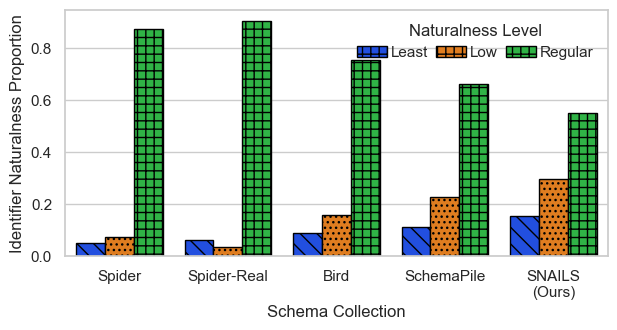

In [30]:
import matplotlib.pyplot as plt
sns.set_theme(style="whitegrid")
nat_plot_df = db_naturalness.reset_index().melt(
    id_vars=["DATABASE_NAME"],
    value_vars=[
        "N1_PERC",
        "N2_PERC",
        "N3_PERC",
        "COMBINED"
    ],
    value_name="Identifier Naturalness Proportion",
    var_name="naturalness"
)
nat_plot_df["Database"] = nat_plot_df.DATABASE_NAME.apply(
    lambda x: f"{database_label_dict[x]}" if x in (
        "bird-all", "spider", "SchemaPile", "Spider-Realistic"
        )
    else f"SNAILS\n(Ours)"#-{database_label_dict[x]}"
)
nat_plot_df["DB_ORDER"] = nat_plot_df.Database.apply(
    lambda x: {
        "Spider": 50,
        "Spider-Real": 40,
        "Bird": 30,
        "SchemaPile": 20,
        "SNAILS\n(Ours)": 10
    }[x]
)
nat_plot_df["naturalness"] = nat_plot_df.naturalness.apply(
    lambda x: x.split("_")[0]
)
nat_plot_df['Naturalness Level'] = nat_plot_df.naturalness.apply(
    lambda x: cat_label_dict[x]
    )

nat_plot_df.sort_values(
    by=["DB_ORDER", "naturalness"], 
    inplace=True,
    ascending=False
    )

f, ax = plt.subplots()
f.set_size_inches(7, 3.2)

# for row in nat_plot_df.sort_values(by=['Naturalness Level', 'value']).query("naturalness == 'combined'")[['Database Label', 'value']].itertuples():
#     ax.plot(row[1], row.value, marker='*', markersize=10, color='black')
plt.xticks(rotation=0)
hatches = ['\\\\', '...', '++']

bar = sns.barplot(
    data=nat_plot_df.query(
        "naturalness != 'COMBINED'"
        ),
    y='Identifier Naturalness Proportion',
    x='Database',
    hue='Naturalness Level',
    orient='v',
    edgecolor='black',
    palette='bright',
    errorbar=None
)
for i, thisbar in enumerate(bar.patches):
    if i < 5:
        thisbar.set_hatch(hatches[0])
    elif i < 10:
        thisbar.set_hatch(hatches[1])
    else:
        thisbar.set_hatch(hatches[2])
# for item in ax.get_xticklabels():
#     ax.plot(
#         item.get_position()[0], 
#         nat_plot_df.query("`Database` == @item.get_text() and naturalness == 'COMBINED'")['Identifier Naturalness Proportion'].values[0], 
#         marker='_', 
#         markersize=10, 
#         color='black'
#         )
ax.legend(
    title='Naturalness Level', 
    loc='upper right', 
    ncol=4, 
    frameon=False, 
    columnspacing=.5, 
    handletextpad=0.25,
    )

ax.set_xlabel('Schema Collection')
ax.set_ylabel('Identifier Naturalness Proportion')
ax.figure.savefig("./figure_output/benchmark_naturalness_compare.pdf", dpi=300, bbox_inches="tight")
ax.figure.savefig("./figure_output/benchmark_naturalness_compare.png", dpi=300)